In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Toy Example

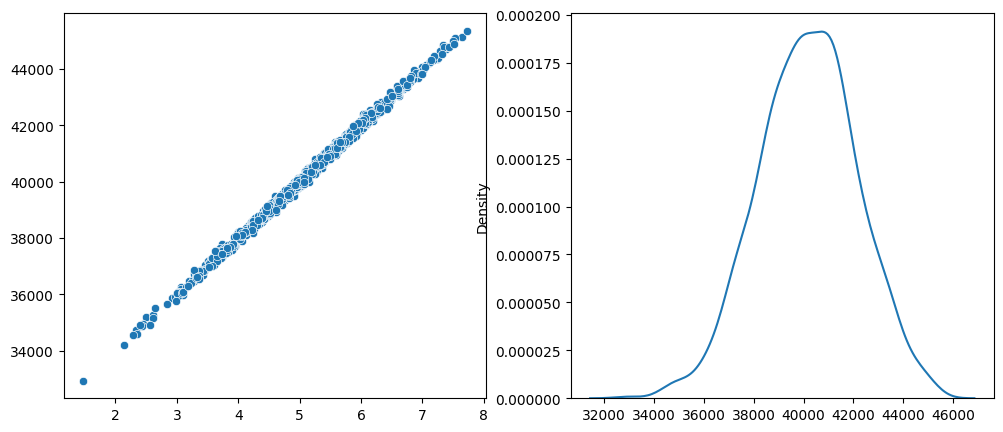

In [16]:
x = np.random.normal(5, 1, 1000)
y = 30000 + 2000 * x + np.random.normal(0, 100, 1000)
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.scatterplot(x=x, y=y, ax=ax[0]);
# Apply max-min scaling
y_scaled = (y - y.min()) / (y.max() - y.min())
x_scaled = (x - x.min()) / (x.max() - x.min())
logy = np.log(y)
sns.kdeplot(y, ax=ax[1]);

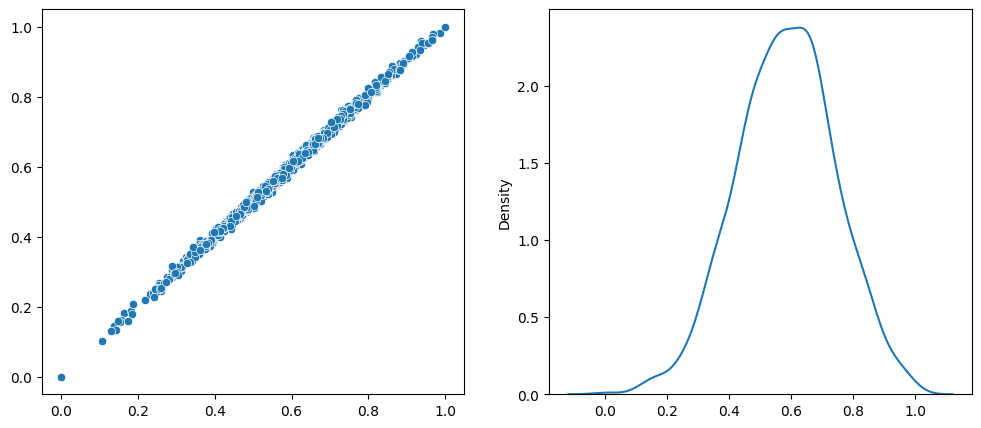

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.scatterplot(x=x_scaled, y=y_scaled, ax=ax[0]);
sns.kdeplot(y_scaled, ax=ax[1]);

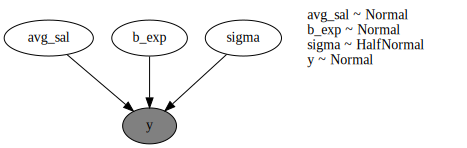

In [18]:
def model(x, y):
    avg_sal = numpyro.sample("avg_sal", dist.Normal(0, 1))
    b_exp = numpyro.sample("b_exp", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    mu = avg_sal + b_exp * x

    numpyro.sample("y", dist.Normal(loc=mu, scale=sigma), obs=y)

numpyro.render_model(model, render_distributions=True, model_args=(x_scaled, y_scaled))

In [33]:
def run_model(model, draws=1000, warmup=1000, chains=2, target_accept_prob=0.95, postprocess_fn=None, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=progress_bar)
        mcmc.run(rng_key, x, y_scaled)
        trace = az.from_numpyro(mcmc)
        return trace

trace = run_model(model)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
az.summary(trace, round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_sal,-0.000058,0.000993,-0.001882,0.001724,0.000033,0.000026,912.984005,786.260519,1.001334
b_exp,1.008677,0.001668,1.005805,1.011945,0.000056,0.000040,887.783256,795.444418,1.001735
sigma,0.008357,0.000184,0.008050,0.008716,0.000008,0.000006,527.600819,768.442604,1.004440


In [29]:
# Convert back to original scale
print(-0.236 * (y.max() - y.min()) + y.min())
print(0.161 * (y.max() - y.min())/1)
print(0.008 * (y.max() - y.min()))

29999.963999289794
2000.7688135077194
99.41708390100469


In [26]:
((y.max() - y.min()) + y.min()) * 0.008

362.87922769596014

In [13]:
np.exp(10.345)

31101.147668171594

In [15]:
np.exp(10.345) * (np.exp(0.050) - 1)

1594.5899394997766

In [17]:
np.exp(10.345)* (np.exp(0.003) -1)

93.44353822921717

In [34]:
import jax

from numpyro.infer.util import initialize_model

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    model,
    model_args=(x, y_scaled),
    dynamic_args=True,
)

In [35]:
logdensity_fn = lambda position: -potential_fn_gen(x, y_scaled)(position)
initial_position = init_params.z

In [36]:
a, b, c = init_params.z.values()
init_params.z

{'avg_sal': Array(-1.5785241, dtype=float32),
 'b_exp': Array(-0.88512325, dtype=float32),
 'sigma': Array(0.74675035, dtype=float32)}

In [37]:
logdensity_fn(position=initial_position)

Array(-6770.0117, dtype=float32)

In [38]:
import blackjax

num_warmup = 1000

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), _ = adapt.run(rng_key, initial_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [39]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [40]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["avg_sal"].block_until_ready()

In [41]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

Average acceptance rate: 0.91
There were 0.00% divergent transitions


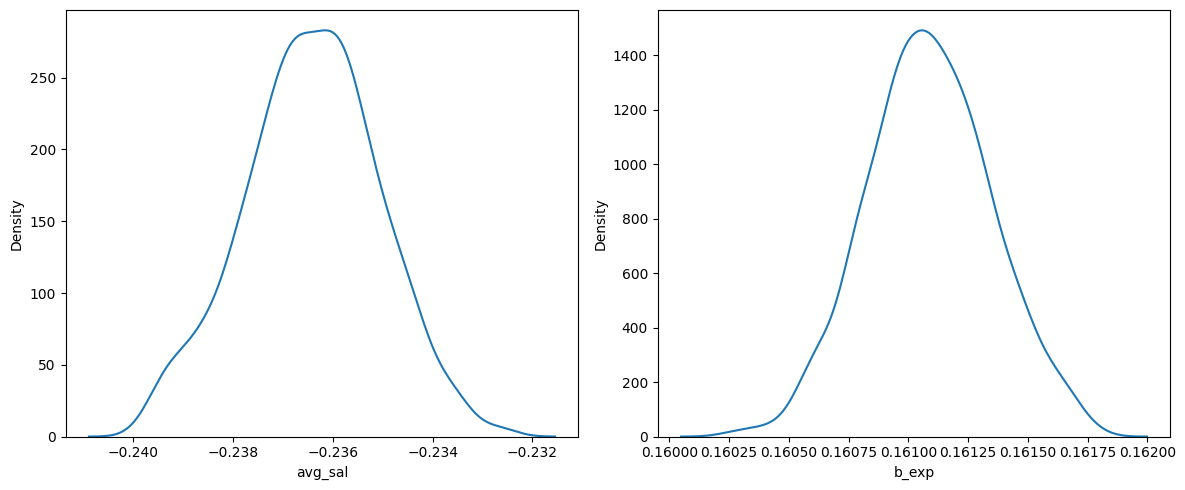

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

samples = states.position

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.kdeplot(samples["avg_sal"], ax=axes[0])
sns.kdeplot(samples["b_exp"], ax=axes[1])
axes[0].set_xlabel("avg_sal")
axes[1].set_xlabel("b_exp")
fig.tight_layout()

# # x-axis in non-scientific notation
axes[0].ticklabel_format(style='plain', axis='x', useOffset=False)

# SLID Data

In [4]:
data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

# data = data.query("year == 1996")
data = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

data.head(3)

,year,industry,occup,exp,salary,sex,elementary_edu,highschool_edu,postsec_edu,undergrad_edu,...,grad_college_refyear,grad_univ_refyear,tenure,union,part_time,public_sector,self_emp,age,firm_size,loc_size
0,1997,"information, culture and recreation",other trades,5.0,78385.474860,0,0,0,1,0,...,0,0,55.0,0,0,0,0,26.0,1,1
1,1997,trade,clerical and supervisor occupations,1.0,32225.139665,0,0,1,0,0,...,0,0,13.0,0,0,0,0,34.0,2,2
2,1997,utilities,machine operators and assemblers in manufacturing,12.0,62708.379888,0,0,0,0,1,...,0,0,138.0,1,0,1,0,34.0,3,3


In [5]:
dataset = data[data["year"]>2006].copy()

In [6]:
dataset.industry = dataset.industry.astype("category")
# Apply max-min scaling
dataset.salary_sc = (dataset.salary - dataset.salary.min()) / (dataset.salary.max() - dataset.salary.min())
dataset.exp_sc = (dataset.exp - dataset.exp.min()) / (dataset.exp.max() - dataset.exp.min())
dataset.tenure_sc = (dataset.tenure - dataset.tenure.min()) / (dataset.tenure.max() - dataset.tenure.min())
dataset.age_sc = (dataset.age - dataset.age.min()) / (dataset.age.max() - dataset.age.min())

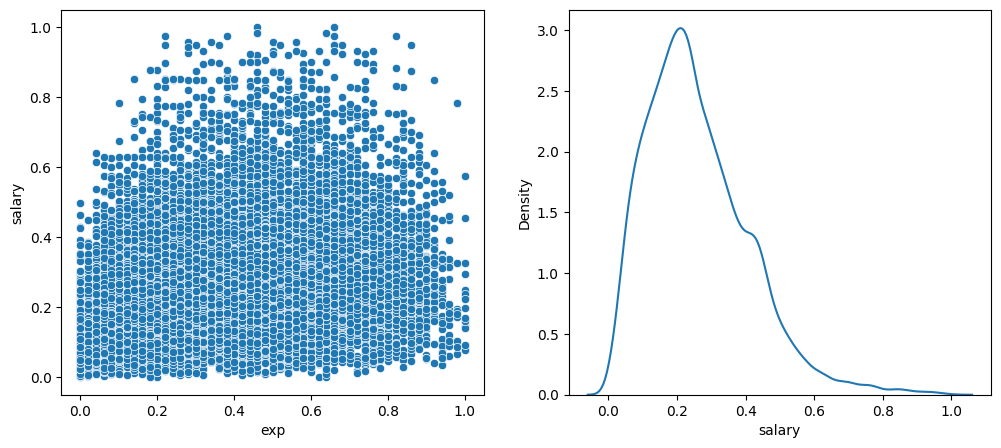

In [7]:
# Plot the data
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.scatterplot(x=dataset.exp_sc, y=dataset.salary_sc, ax=ax[0]);
sns.kdeplot(dataset.salary_sc, ax=ax[1]);

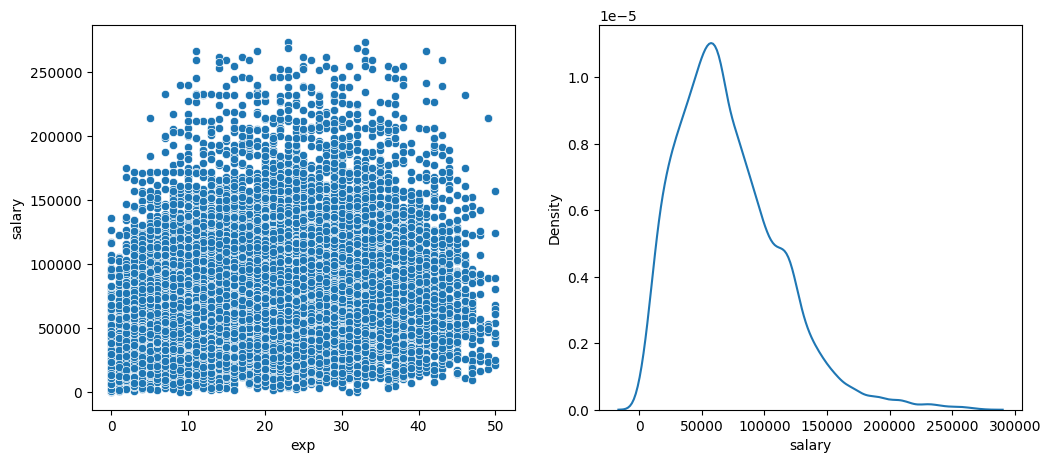

In [8]:
# Plot the data withouth scaling
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
sns.scatterplot(x=dataset.exp, y=dataset.salary, ax=ax[0]);
sns.kdeplot(dataset.salary, ax=ax[1]);

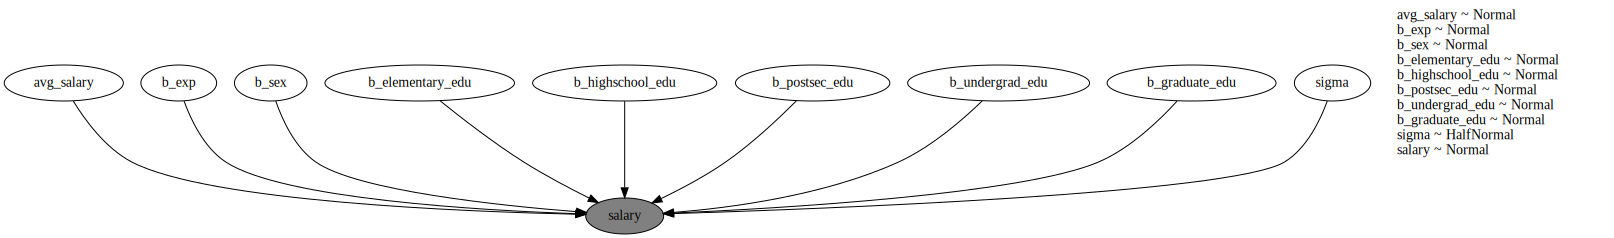

In [9]:
def test(salary, exp, sex, elementary_edu, highschool_edu, postsec_edu, undergrad_edu, graduate_edu): #, grad_highschool_refyear,
        #  grad_college_refyear, grad_univ_refyear, tenure, union, part_time, public_sector, self_emp, age, firm_size, loc_size):
    avg_salary = numpyro.sample("avg_salary", dist.Normal(0, 1))
    b_exp = numpyro.sample("b_exp", dist.Normal(0, 1))
    b_sex = numpyro.sample("b_sex", dist.Normal(0, 1))
    b_elementary_edu = numpyro.sample("b_elementary_edu", dist.Normal(0, 1))
    b_highschool_edu = numpyro.sample("b_highschool_edu", dist.Normal(0, 1))
    b_postsec_edu = numpyro.sample("b_postsec_edu", dist.Normal(0, 1))
    b_undergrad_edu = numpyro.sample("b_undergrad_edu", dist.Normal(0, 1))
    b_graduate_edu = numpyro.sample("b_graduate_edu", dist.Normal(0, 1))
    # b_grad_highschool_refyear = numpyro.sample("b_grad_highschool_refyear", dist.Normal(0, 1))
    # b_grad_college_refyear = numpyro.sample("b_grad_college_refyear", dist.Normal(0, 1))
    # b_grad_univ_refyear = numpyro.sample("b_grad_univ_refyear", dist.Normal(0, 1))
    # b_tenure = numpyro.sample("b_tenure", dist.Normal(0, 1))
    # b_union = numpyro.sample("b_union", dist.Normal(0, 1))
    # b_part_time = numpyro.sample("b_part_time", dist.Normal(0, 1))
    # b_public_sector = numpyro.sample("b_public_sector", dist.Normal(0, 1))
    # b_self_emp = numpyro.sample("b_self_emp", dist.Normal(0, 1))
    # b_age = numpyro.sample("b_age", dist.Normal(0, 1))
    # b_firm_size = numpyro.sample("b_firm_size", dist.Normal(0, 1))
    # b_loc_size = numpyro.sample("b_loc_size", dist.Normal(0, 1))
    
    # shape = numpyro.sample("shape", dist.Uniform(1, 100))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    mu = (avg_salary + b_exp * exp + b_sex * sex + b_elementary_edu * elementary_edu + b_highschool_edu * highschool_edu
                + b_postsec_edu * postsec_edu + b_undergrad_edu * undergrad_edu + b_graduate_edu * graduate_edu)

    # mu = jnp.exp(avg_salary + b_exp * exp + b_sex * sex + b_elementary_edu * elementary_edu + b_highschool_edu * highschool_edu
    #             + b_postsec_edu * postsec_edu + b_undergrad_edu * undergrad_edu + b_graduate_edu * graduate_edu)
                # + b_grad_highschool_refyear * grad_highschool_refyear + b_grad_college_refyear * grad_college_refyear
                # + b_grad_univ_refyear * grad_univ_refyear + b_tenure * tenure + b_union * union + b_part_time * part_time
                # + b_public_sector * public_sector + b_self_emp * self_emp + b_age * age + b_firm_size * firm_size
                # + b_loc_size * loc_size)

    # rate = shape / mu
    

    # numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=salary)
    numpyro.sample("salary", dist.Normal(loc=mu, scale=sigma), obs=salary)

numpyro.render_model(test, render_distributions=True, model_args=(dataset.salary_sc.values, dataset.exp_sc.values,
                                                                  dataset.sex.values, dataset.elementary_edu.values,
                                                                  dataset.highschool_edu.values, dataset.postsec_edu.values,
                                                                  dataset.undergrad_edu.values, dataset.graduate_edu.values))
                                                                #   dataset.grad_highschool_refyear.values, dataset.grad_college_refyear.values,
                                                                #   dataset.grad_univ_refyear.values, dataset.tenure.values,
                                                                #   dataset.union.values, dataset.part_time.values,
                                                                #   dataset.public_sector.values, dataset.self_emp.values,
                                                                #   dataset.age.values, dataset.firm_size.values,
                                                                #   dataset.loc_size.values))

In [10]:
def run_model(model, draws=10000, warmup=10000, chains=4, target_accept_prob=0.95, postprocess_fn=None, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=progress_bar)
        mcmc.run(rng_key, dataset.salary_sc.values, dataset.exp_sc.values,
                        dataset.sex.values, dataset.elementary_edu.values,
                        dataset.highschool_edu.values, dataset.postsec_edu.values,
                        dataset.undergrad_edu.values, dataset.graduate_edu.values)
                        # dataset.grad_highschool_refyear.values, dataset.grad_college_refyear.values,
                        # dataset.grad_univ_refyear.values, dataset.tenure_sc.values,
                        # dataset.union.values, dataset.part_time.values,
                        # dataset.public_sector.values, dataset.self_emp.values,
                        # dataset.age_sc.values, dataset.firm_size.values,
                        # dataset.loc_size.values)
        trace = az.from_numpyro(mcmc)
        return trace

trace = run_model(test)

I0000 00:00:1695416257.946762   85473 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

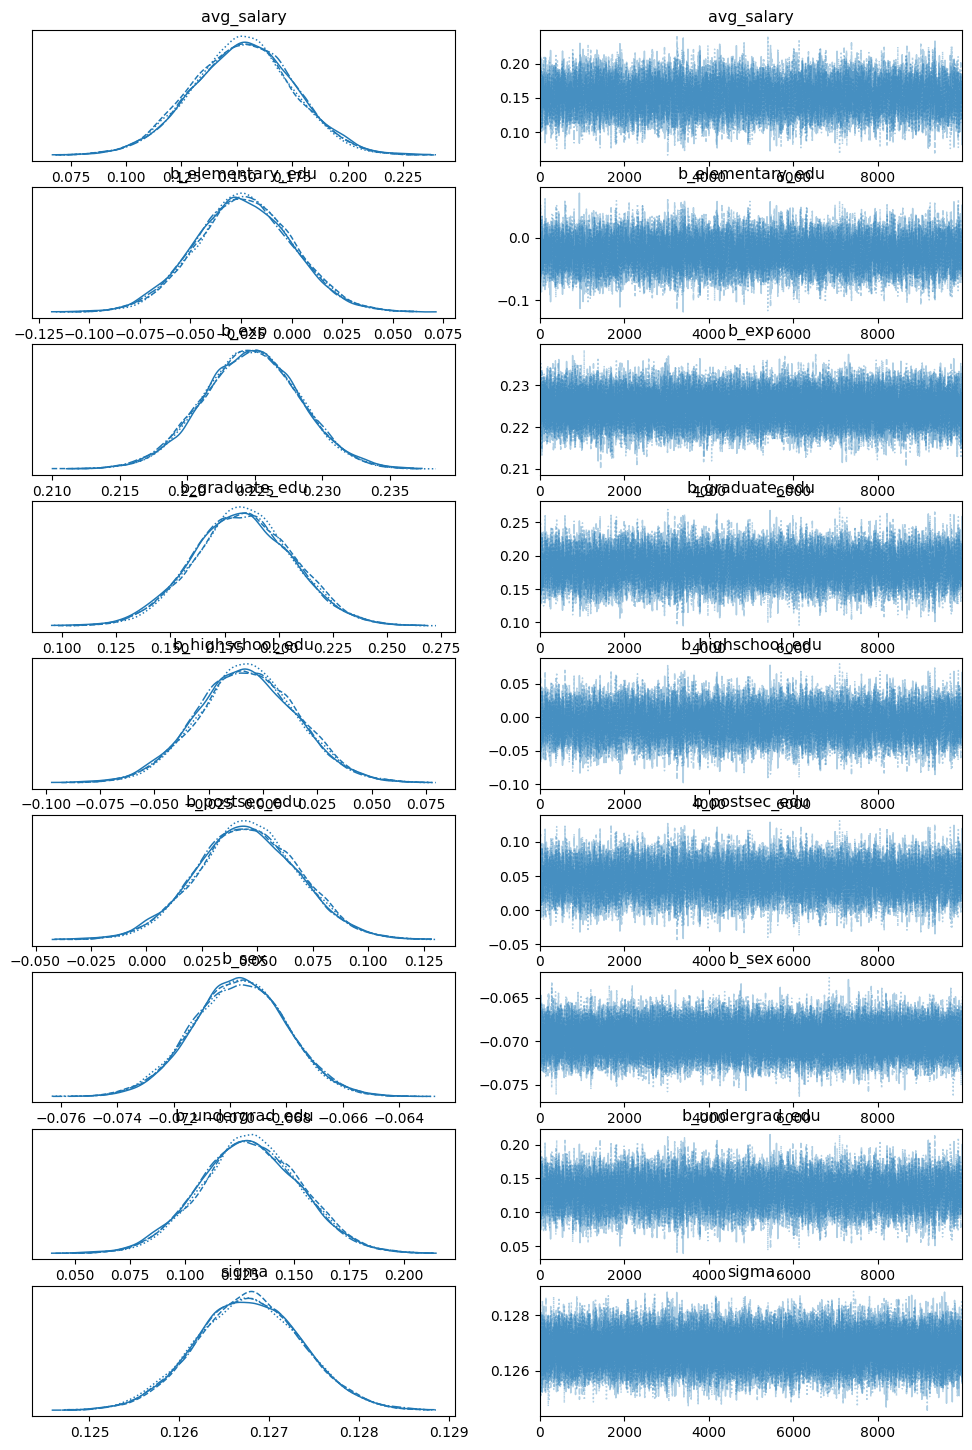

In [11]:
az.plot_trace(trace);

In [31]:
# Fit a linear regression model using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(dataset[["exp"]], dataset[["salary"]])

# Make predictions using the testing set
salary_pred = regr.predict(dataset[["exp"]])

# The coefficients and intercept
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[1138.683334]]
Intercept: 
 [50743.75749355]


In [12]:
az.summary(trace, round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_salary,0.152639,0.022943,0.110379,0.196611,0.000277,0.000197,6853.887393,10157.941373,1.000593
b_elementary_edu,-0.023469,0.023925,-0.066681,0.023278,0.000283,0.000200,7144.389005,11242.568394,1.000549
b_exp,0.224723,0.003562,0.217969,0.231356,0.000022,0.000015,26804.403763,22896.254774,1.000190
b_graduate_edu,0.183583,0.023022,0.140310,0.226755,0.000277,0.000196,6900.720311,10454.801928,1.000616
b_highschool_edu,-0.007217,0.022931,-0.050891,0.035144,0.000277,0.000196,6843.303907,10310.592009,1.000628
b_postsec_edu,0.045594,0.022900,0.003443,0.089473,0.000277,0.000196,6844.929976,10483.598830,1.000632
b_sex,-0.069657,0.001657,-0.072831,-0.066596,0.000009,0.000007,30551.534635,24128.730207,1.000083
b_undergrad_edu,0.129893,0.022958,0.086912,0.173167,0.000277,0.000196,6843.331292,10417.224056,1.000611
sigma,0.126777,0.000589,0.125646,0.127864,0.000004,0.000003,27423.105154,23209.387901,1.000165


In [76]:
np.exp(10.827842)

50404.815745462045

In [77]:
np.exp(10.827842) * (np.exp(0.905604 / (dataset.exp.max() - dataset.exp.min())) - 1)

921.2537818242396

In [14]:
import jax

from numpyro.infer.util import initialize_model

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    test,
    model_args=(dataset.salary.values, dataset.exp_sc.values,
                        dataset.sex.values, dataset.elementary_edu.values,
                        dataset.highschool_edu.values, dataset.postsec_edu.values,
                        dataset.undergrad_edu.values, dataset.graduate_edu.values),
                        # dataset.grad_highschool_refyear.values, dataset.grad_college_refyear.values,
                        # dataset.grad_univ_refyear.values, dataset.tenure_sc.values,
                        # dataset.union.values, dataset.part_time.values,
                        # dataset.public_sector.values, dataset.self_emp.values,
                        # dataset.age_sc.values, dataset.firm_size.values,
                        # dataset.loc_size.values),
    dynamic_args=True,
)

In [15]:
logdensity_fn = lambda position: -potential_fn_gen(dataset.salary.values, dataset.exp_sc.values,
                        dataset.sex.values, dataset.elementary_edu.values,
                        dataset.highschool_edu.values, dataset.postsec_edu.values,
                        dataset.undergrad_edu.values, dataset.graduate_edu.values)(position)
                        # dataset.grad_highschool_refyear.values, dataset.grad_college_refyear.values,
                        # dataset.grad_univ_refyear.values, dataset.tenure_sc.values,
                        # dataset.union.values, dataset.part_time.values,
                        # dataset.public_sector.values, dataset.self_emp.values,
                        # dataset.age_sc.values, dataset.firm_size.values,
                        # dataset.loc_size.values)(position)
initial_position = init_params.z

In [16]:
initial_position

{'avg_salary': Array(-1.5785241, dtype=float32),
 'b_exp': Array(-0.88512325, dtype=float32),
 'b_sex': Array(0.74675035, dtype=float32),
 'b_elementary_edu': Array(0.34380293, dtype=float32),
 'b_highschool_edu': Array(-0.9668493, dtype=float32),
 'b_postsec_edu': Array(1.6393332, dtype=float32),
 'b_undergrad_edu': Array(1.4018683, dtype=float32),
 'b_graduate_edu': Array(-1.0986514, dtype=float32),
 'sigma': Array(-0.90934944, dtype=float32)}

In [27]:
init_params_position = {'avg_salary': 0.1,
 'b_exp': 0.1,
 'b_sex': 0.1,
 'b_elementary_edu': 0.1,
 'b_highschool_edu': 0.1,
 'b_postsec_edu': 0.1,
 'b_undergrad_edu': 0.1,
 'b_graduate_edu': 0.1,
 'b_grad_highschool_refyear': 0.1,
 'b_grad_college_refyear': 0.1,
 'b_grad_univ_refyear': 0.1,
 'b_tenure': 0.1,
 'b_union': 0.1,
 'b_part_time': 0.1,
 'b_public_sector': 0.1,
 'b_self_emp': 0.1,
 'b_age': 0.1,
 'b_firm_size': 0.1,
 'b_loc_size': 0.1,
 'sigma': 0.1}

In [28]:
logdensity_fn(position=initial_position)

Array(-4.923926e+14, dtype=float32)

In [29]:
import blackjax

num_warmup = 10000

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), _ = adapt.run(rng_key, init_params_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [30]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [31]:
num_sample = 10000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["avg_salary"].block_until_ready()

In [32]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

Average acceptance rate: 1.00
There were 100.00% divergent transitions


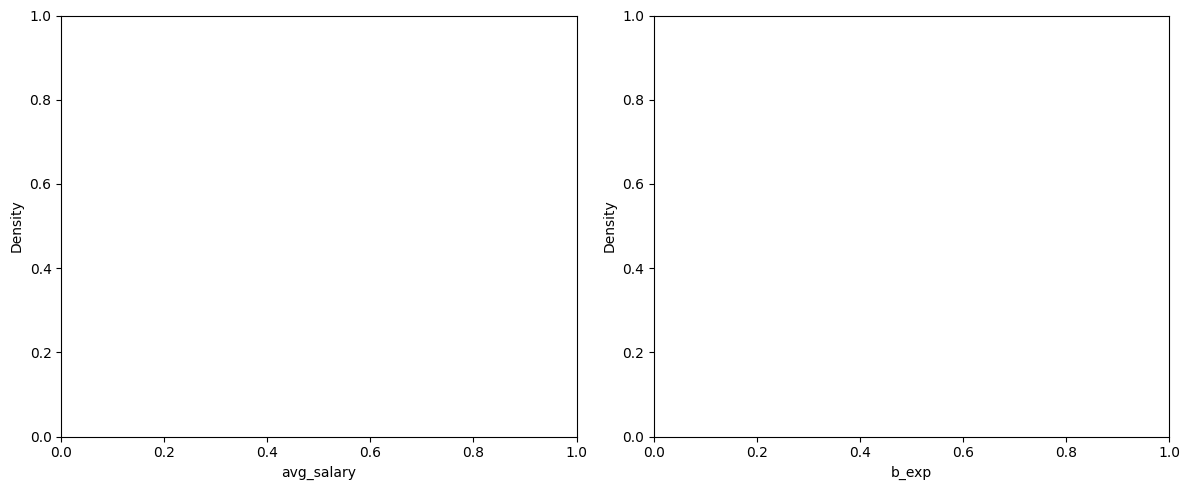

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

samples = states.position

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.kdeplot(samples["avg_salary"], ax=axes[0])
sns.kdeplot(samples["b_exp"], ax=axes[1])
axes[0].set_xlabel("avg_salary")
axes[1].set_xlabel("b_exp")
fig.tight_layout()

In [29]:
import numpy as np


J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]) * 1000
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])*100

In [30]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam


def eight_schools_noncentered(J, sigma, y=None):
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.HalfCauchy(5))
    with numpyro.plate("J", J):
        with numpyro.handlers.reparam(config={"theta": TransformReparam()}):
            theta = numpyro.sample(
                "theta",
                dist.TransformedDistribution(
                    dist.Normal(0.0, 1.0), dist.transforms.AffineTransform(mu, tau)
                ),
            )
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

In [31]:
import jax
from numpyro.infer.util import initialize_model

rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools_noncentered,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

In [32]:
logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z

In [33]:
import blackjax

num_warmup = 2000

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), _ = adapt.run(rng_key, initial_position, num_warmup)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [34]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [35]:
num_sample = 2000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [36]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.94
There were 0.00% divergent transitions


In [37]:
states.position["mu"].shape

(2000,)

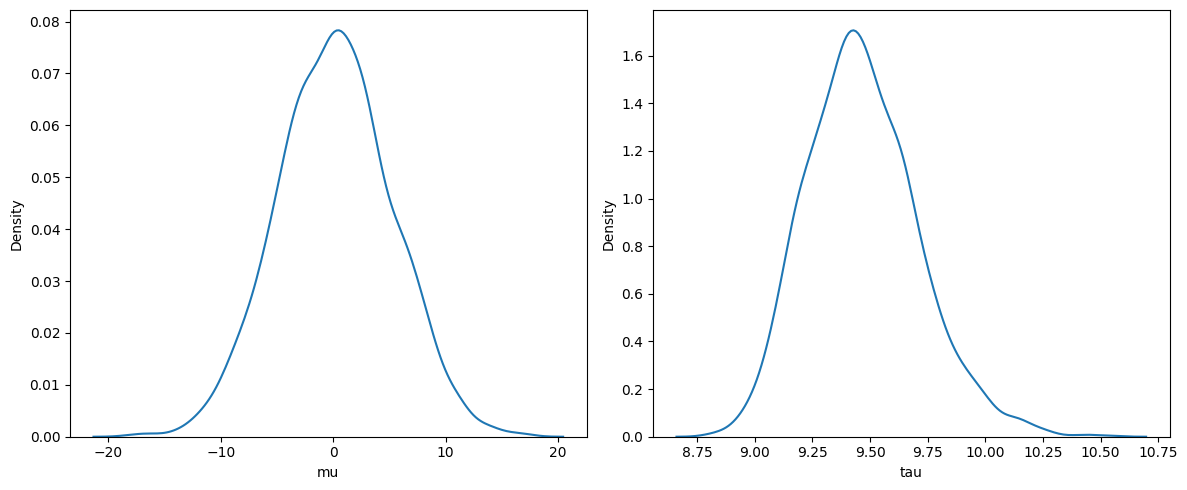

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt

samples = states.position

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.kdeplot(samples["mu"], ax=axes[0])
sns.kdeplot(samples["tau"], ax=axes[1])
axes[0].set_xlabel("mu")
axes[1].set_xlabel("tau")
fig.tight_layout()